# Creating a new Machine Scoring Method
Hello!  This in Matt's quick tutorial on how to create and implement a new direct scoring method and then testing it on a target.

## Step 1: Load nessecary modules

In [10]:
# Add python modules
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# Add parent directory for custom modules
from sys import path as sysPath
sysPath.append('../')
sysPath.append('../Machine_Score/')

# Load custom modules that simr has loaded
import main_SIMR as simr
gm = simr.gm
im = simr.im
ic = simr.ic
ms = simr.ms
sa = simr.sa
dc = simr.ms.dc

simr.test()
gm.test()
im.test()
ic.test()
ms.test()
dc.test()
sa.test()

SIMR: Hi!  You're in Matthew's main program for all things galaxy collisions
GM: Hi!  You're in Matthew's module for generally useful functions and classes
IM: Hi!  You're in Matthew's information module for SPAM
IC: Hi!  You're in Matthew's main code for all things image creation.
MS: Hi!  You're in Matthew's SIMR module for all things machine scoring images
DC: Hi!  You're in direct_image_compare.py
SA: Hi!  You're in Matthew's Main program for score analysis!


___
## Step 2: Load Target and single Run Info class
Needed for loading the target image and running through models later.

In [11]:
tDir = '../targetDir'
tDir = gm.validPath(tDir)

tInfo = im.target_info_class( targetDir = tDir, printAll=False)
if tInfo.status == False:
    print("WARNING: target info class bad")
else:
    print("Target Good!")

# Get run info class
rInfo = tInfo.getRunInfo( rID='run_0000' )

if rInfo.status == False:
    print("WARNING")
else:
    print("Run '%s' Good!"%rInfo.get('run_id'))

Target Good!
Run 'run_0000' Good!


---
## Step 4: Load score parameter file
For loading in the the new score parameter file.  You can edit this file as you see fit

In [12]:
tParams = tInfo.getImageParams()
#gm.pprint(tParams)
for key in tParams:
    print(key)

# Create a new score param in tInfo if needed
new_name = 'new_score'
new_params = {}

# Copy desired starting parameter.
new_params[new_name] = deepcopy( tParams['zoo_0'] )
new_params[new_name]['name'] = new_name
new_params[new_name]['cmpArg']['function_name'] = 'test_compare'
gm.pprint(new_params)

tInfo.addImageParams(new_params, overWrite = True)


zoo_0
new_score
zoo_test
{'new_score': {'cmpArg': {'direct_compare_function': 'absolute_difference',
                          'function_name': 'test_compare',
                          'targetName': 'zoo_0',
                          'targetType': 'target_image',
                          'type': 'direct_image_comparison'},
               'comment': 'Starting '
                          'score '
                          'parameters '
                          'file for '
                          '587722984435351614',
               'imgArg': {'comment': 'Starting '
                                     'image '
                                     'parameters '
                                     'for '
                                     '587722984435351614',
                          'galaxy_centers': {'px': 513,
                                             'py': 514,
                                             'sx': 309,
                                             'sy': 608},


___
## Step 5: Load image for comparison
Load in the target image and a model image for initial comparison

NameError: name 'img2' is not defined

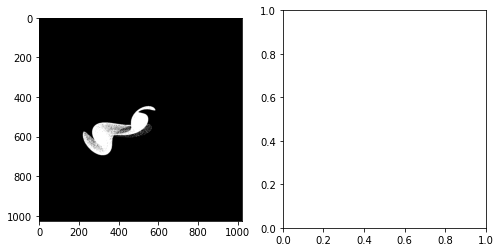

In [8]:
img1 = rInfo.getModelImage( new_params['new_score']['imgArg']['name'] )
img0 = tInfo.getTargetImage( new_params['new_score']['cmpArg']['targetName'] )

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(img1, cmap='gray')
plt.subplot(122)
plt.imshow(img2, cmap='gray')

___
## Step 6: Create the new comparison function!
Note: All direct image comparison take 3 arguments
- 2x images of the same size
- dict of comparison arguments

In [5]:
# Test new scoring method on 2 images directly

def score_ssim( img1, img2, cmpArg ):
    score = -1
    score = ssim( img1, img2 )
    return score

score = score_ssim( img1, img2, None )

print(score)

0.9419514405092195


___
## Step 7: Load new function into direct image module
This will allow the existing code to run the function in a standard new score operation.

In [6]:
# Assign new function to test function in direct image compare
dc.set_test_compare(score_ssim)

# Check if all modules loaded the same function
print("NOTE! All should match")
print('nb:   ',score_ssim)
print('dc:   ',dc.test_compare)
print('ms:   ',ms.dc.test_compare)
print('simr: ',simr.ms.dc.test_compare)


New Score Function:  <function score_ssim at 0x7f1a1d3010d0>
NOTE! All should match
nb:    <function score_ssim at 0x7f1a1d3010d0>
dc:    <function score_ssim at 0x7f1a1d3010d0>
ms:    <function score_ssim at 0x7f1a1d3010d0>
simr:  <function score_ssim at 0x7f1a1d3010d0>


___
## Step 8: Execute new score operation for a single model.
This confirms that the score function operates correcting in the new score pipeline

In [9]:
newRunScoreArg = gm.inArgClass()
newRunScoreArg.setArg( 'rInfo', rInfo )
newRunScoreArg.setArg( 'scoreParams', new_params )
newRunScoreArg.setArg( 'printAll', True )
newRunScoreArg.setArg( 'newScore', True )
newRunScoreArg.setArg( 'overWrite', True )

simr.simr_run( rInfo = rInfo, arg = newRunScoreArg )
rInfo.printScores()

SIMR.pipelineRun: Inputs
	 - rDir: None
	 - rInfo: <class 'Support_Code.info_module.run_info_class'>
SIMR.pipelineRun: 
	 - rInfo:  <Support_Code.info_module.run_info_class object at 0x7f1a29cd74c0>
MS: Run:
MS: scoreName: new_score
MS: target_direct_image_compare: new_score
	 -  paramName: new_score
	 -  modelName: zoo_0
	 - targetName: zoo_0
	 - Read target image
MS: run: Read model image
MS: New Score!: new_score - 0.941951 - 0.941951
IM: run_info_class.printScores()
	 - run_id: r00000
	 - zoo_merger: 0.945946
	 - machine_scores: 5
	 - zoo_test: 0.843128
	 - zoo_0: 0.753202
	 - zoo_test_3: 0.828484
	 - new_score: 0.941951
	 - zoo_2: 0.846133


___
## Step 9: Execute new score operation for a complete target.
Execute the new function for a target and see if it works across many models

In [19]:
newTarget = gm.inArgClass()
newTarget.setArg( 'tInfo', tInfo )
newTarget.setArg( 'scoreParams', new_params )
newTarget.setArg( 'printAll', False )
newTarget.setArg( 'newScore', True )
#newTarget.setArg( 'overWrite', True )

simr.simr_target( arg=newTarget )

SIMR: pipelineTarget: input
	 - tDir: None
	 - tInfo: <class 'NoneType'>
SIMR: simr_target status:
	 - tInfo.status: True
SIMR: new_target_scores:
	 - tInfo: True
	 - Scores already exist


***
## Step 10: View results!
View if your new method does well or not.

<AxesSubplot:title={'center':'new_score:\nCorr: -0.1663'}, xlabel='zoo_merger_score', ylabel='new_score'>

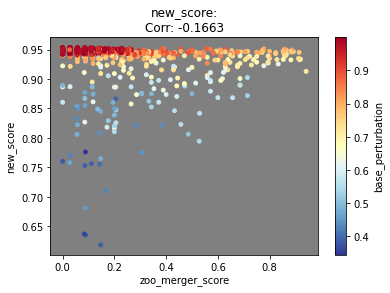

In [20]:
scores = tInfo.getScores()
sa.getNamedPlot(scores)

___
## Step 11: Add new function to direct_image_comparison.py

## Step 12: Rename parameter and save
- Create a new dict of the new score parameter
    - Parameter name
    - cmpMethod name: Match name of function in directory_image_compare
   

In [12]:
param = deepcopy( new_params['new_score'] )
param['name'] = 'base0_ssim'
param['cmpArg']['cmpMethod'] = 'ssim'

gm.pprint(param)

{'cmpArg': {'cmpMethod': 'ssim'},
 'imgArg': {'name': 'default',
            'pType': 'default'},
 'name': 'base0_ssim',
 'scoreType': 'target',
 'simArg': {'nPts': '100k',
            'name': '100k'},
 'targetName': 'zoo'}


___
## Step 13: Save in a score parameter file

In [13]:
# Load existing score parameter file
pLoc = gm.validPath('../param/base0.json')
print(pLoc,'\n')
baseParamClass = im.group_score_parameter_class(pLoc = pLoc)

#gm.pprint(baseParams)

# Add new score parameter to dict
baseParamClass.group[ param['name'] ] = param
gm.pprint(baseParamClass.group)
baseParamClass.saveParam( saveLoc = '../param/base0.json' )


/mnt/c/Users/ogden/OneDrive/Desktop/galStuff/galaxyJSPAM/param/base0.json 

{'base0_bcorr0': {'cmpArg': {'cmpMethod': 'binary_correlation'},
                  'imgArg': {'name': 'default',
                             'pType': 'default'},
                  'name': 'base0_bcorr0',
                  'scoreType': 'target',
                  'simArg': {'nPts': '100k',
                             'name': '100k'},
                  'targetName': 'zoo'},
 'base0_bcorr1': {'cmpArg': {'cmpMethod': 'binary_correlation',
                             'h1': 120,
                             'h2': 120},
                  'imgArg': {'name': 'default',
                             'pType': 'default'},
                  'name': 'base0_bcorr1',
                  'scoreType': 'target',
                  'simArg': {'nPts': '100k',
                             'name': '100k'},
                  'targetName': 'zoo'},
 'base0_bcorr2': {'cmpArg': {'cmpMethod': 'binary_correlation',
                          

___
## Step 14: Have target run the score parameter file you just updated

In [14]:
newTarget = gm.inArgClass()
newTarget.setArg( 'tInfo', tInfo )
newTarget.setArg( 'scoreParams', baseParamClass.group )
newTarget.setArg( 'printAll', False )
newTarget.setArg( 'newScore', True )
#newTarget.setArg( 'overWrite', True )

#gm.pprint(newTarget.get('scoreParams'))

simr.simr_target( arg=newTarget )

SIMR: pipelineTarget: input
	 - tDir: None
	 - tInfo: <class 'NoneType'>
SIMR: simr_target status:
	 - tInfo.status: True
SIMR: new_target_scores:
	 - tInfo: True
	 - Runs needing scores: 1293
100.0% - 1293 / 1293	  



IM: Target.gatherRunInfos.
GM: Printing Input arguments
	- printBase - <class 'bool'> :  True
	- printAll - <class 'bool'> :  False
	- nProc - <class 'int'> :  -1
	- simple - <class 'bool'> :  False
	- runDir - <class 'NoneType'> :  None
	- sdssDir - <class 'NoneType'> :  None
	- targetDir - <class 'NoneType'> :  None
	- dataDir - <class 'NoneType'> :  None

0.2% - 3 / 1293	  
0.6% - 8 / 1293	  
100.0% - 1293 / 1293	  






IM: Target.saveInfoFile():
	 - Saving target info file...
IM: Target.saveInfoFile():
	 - Saving target info file...
IM: Target.saveInfoFile():
	 - Saving target info file...


___
## Step 15: view target results of new score function! Again!

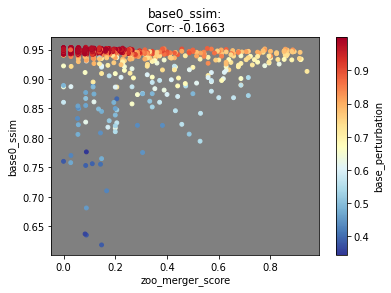

In [17]:
scores = tInfo.getScores()
ax = sa.getNamedPlot(scores, sName = 'base0_ssim' )